# VQE using cuStateVec

This notebook will give a brief tutorial on how to use cuQuantum to accelerate a simple variational quantum eigensolver (VQE) example using the DGX cuQuantum appliance. We will first compare the performance of the native CPU backend compared to the GPU backend using cuStateVec, observing a significant increase in performance for a 25 qubit system. We will then look at some of the functionality of cuTensorNet to simulate a much larger 36 qubit system.

Materials are adopted from:

https://quantumai.google/cirq/experiments/variational_algorithm
https://github.com/NVIDIA/cuQuantum/blob/main/python/samples/cutensornet/circuit_converter/cirq_advanced.ipynb

## Define the ansatz

In this first section we will generate a random Ising Hamiltonian on a square grid and define a few helper functions to generate our VQE ansatz. Our Hamiltonian takes the following form:

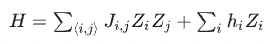

Where J_i,j and h_i are randomly assigned the values +1 or -1.

In [ ]:
import cirq
import qsimcirq
import time
import copy
import random

In [ ]:
def rand2d(rows, cols):
    return[[random.choice([+1,-1]) for _ in range(cols)] for _ in range(rows)]
def random_instance(length):
    h=rand2d(length, length)
    jr=rand2d(length-1,length)
    jc=rand2d(length,length-1)
    return(h,jr,jc)

h,jr,jc=random_instance(3)

In [ ]:
print(h)
print(jr)
print(jc)

#### Prepare plus state

Our ansatz starts in the all plus state and we will evolve it using a QAOA-type evolution, where the Ising Hamiltonian evolves the starting all plus state and we add a "mixing" term given by the "x layer" below.

In [ ]:
def prepare_plus_layer(length):
    for i in range(length):
        for j in range(length):
            yield cirq.H(cirq.GridQubit(i,j))

In [ ]:
circuit = cirq.Circuit()
circuit.append(prepare_plus_layer(2))
print(circuit)

#### x layer

In [ ]:
def rot_x_layer(length, half_turns):
    """Yields X rotations by half_turns on a square grid of given length."""

    # Define the gate once and then re-use it for each Operation.
    rot = cirq.XPowGate(exponent=half_turns)

    # Create an X rotation Operation for each qubit in the grid.
    for i in range(length):
        for j in range(length):
            yield rot(cirq.GridQubit(i, j))

In [ ]:
circuit = cirq.Circuit()
circuit.append(rot_x_layer(2,0.1))
print(circuit)

#### Z layer

In [ ]:
def rot_z_layer(h, half_turns):
    gate=cirq.ZPowGate(exponent=half_turns)
    for i, h_row in enumerate(h):
        for j, h_ij in enumerate(h_row):
            if h_ij==1:
                yield gate(cirq.GridQubit(i,j))

In [ ]:
circuit = cirq.Circuit()
circuit.append(rot_z_layer(h, 0.1))

In [ ]:
print(circuit)

#### Entangling layer

Apply a CZ(theta) gate if J=+1. If J=-1, flip both qubits and apply CZ(theta)

In [ ]:
def rot_11_layer(jr, jc, half_turns):
    """Yields rotations about |11> conditioned on the jr and jc fields."""
    cz_gate = cirq.CZPowGate(exponent=half_turns)    
    for i, jr_row in enumerate(jr):
        for j, jr_ij in enumerate(jr_row):
            q = cirq.GridQubit(i, j)
            q_1 = cirq.GridQubit(i + 1, j)
            if jr_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)
            yield cz_gate(q, q_1)
            if jr_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)

    for i, jc_row in enumerate(jc):
        for j, jc_ij in enumerate(jc_row):
            q = cirq.GridQubit(i, j)
            q_1 = cirq.GridQubit(i, j + 1)
            if jc_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)
            yield cz_gate(q, q_1)
            if jc_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)

## Put it all together to generate the ansatz

Using our helper functions above, we generate the ansatz below with a rotation of 0.3 for each of our ansatz parameters.

In [ ]:
#define a 5x5 qubit ansatz

length=5
qubits=cirq.GridQubit.square(length)
h,jr, jc = random_instance(length)

circuit=cirq.Circuit()
circuit.append(prepare_plus_layer(length))
circuit.append(rot_z_layer(h,0.3))
circuit.append(rot_11_layer(jr,jc,0.3))
circuit.append(rot_x_layer(length, 0.3))
circuit.append(cirq.measure(*qubits, key='x'))

In [ ]:
print(circuit)

## Run the simulation 

Let's now define our two simulators, one using the CPU and one using the GPU with cuQuantum. We'll first run circuit on the CPU and compare its performance with the GPU backend.

In [ ]:
# Define the simulators
# Default simulator
simulator = cirq.Simulator()

# cuQuantum enabled GPU simulator
ngpus=1
qsim_options=qsimcirq.QSimOptions(
    max_fused_gate_size=2
    , cpu_threads=1
    , gpu_mode = ngpus
    , use_sampler = True
    , disable_gpu = False
)

simulator_cuQ=qsimcirq.QSimSimulator(qsim_options)

In [ ]:
# Default simulator
start=time.time()
results = simulator.run(circuit, repetitions=100)
print(results.histogram(key='x'))
print("CPU runtime: {:.2f}s".format(time.time() - start))

In [ ]:
# cuQuantum backend

start=time.time()
results = simulator_cuQ.run(circuit, repetitions=100)
print(results.histogram(key='x'))
print("GPU runtime: {:.2f}s".format(time.time() - start))

We see that the GPU runtime is significantly faster than the CPU runtime for the simulation!

## Calculate the energy expectation

For VQE, we want to parameterize the ansatz and find the parameters which minimize the energy of the ansatz for our given Hamiltonian. The functions below calculate the energy expectation value given the output of our simulation.

In [ ]:
import numpy as np

def energy_func(length, h, jr, jc):
    def energy(measurements):
        # Reshape measurement into array that matches grid shape.
        meas_list_of_lists = [measurements[i * length:(i + 1) * length]
                              for i in range(length)]
        # Convert true/false to +1/-1.
        pm_meas = 1 - 2 * np.array(meas_list_of_lists).astype(np.int32)

        tot_energy = np.sum(pm_meas * h)
        for i, jr_row in enumerate(jr):
            for j, jr_ij in enumerate(jr_row):
                tot_energy += jr_ij * pm_meas[i, j] * pm_meas[i + 1, j]
        for i, jc_row in enumerate(jc):
            for j, jc_ij in enumerate(jc_row):
                tot_energy += jc_ij * pm_meas[i, j] * pm_meas[i, j + 1]
        return tot_energy
    return energy

def obj_func(result):
    energy_hist = result.histogram(key='x', fold_func=energy_func(length, h, jr, jc))
    return np.sum([k * v for k,v in energy_hist.items()]) / result.repetitions


In [ ]:
print(results.histogram(key='x', fold_func=energy_func(length, h, jr, jc)))
print(f'Value of the objective function <H> {obj_func(results)}')

## Parameterize the ansatz to minimize the energy

Let's now parameterize our circuit. We'll sweep over three angles: alpha, beta, and gamma, which parameterize the helper functions generating our ansatz. Sweeping over 10 angles for each parameter gives us 1000 circuits to run. With the CPU backend, this can take over an hour to run! We'll use the cuQuantum GPU backend and should get the results back in less than a minute.

In [ ]:
# Parameterize the circuits for a VQE sweep
import sympy

# Define our parameters symbolically 
alpha = sympy.Symbol('alpha')
beta = sympy.Symbol('beta')
gamma = sympy.Symbol('gamma')

# Define the circuit
circuit = cirq.Circuit()
circuit.append(prepare_plus_layer(length))
circuit.append(rot_z_layer(h,alpha))
circuit.append(rot_11_layer(jr,jc,beta))
circuit.append(rot_x_layer(length, gamma))
circuit.append(cirq.measure(*qubits, key='x'))

print(circuit)

In [ ]:
# Define the sweep size
sweep_size = 10
start=time.time()

sweep = (cirq.Linspace(key='alpha', start=0.0, stop=1.0, length=sweep_size)
         * cirq.Linspace(key='beta', start=0.0, stop=1.0, length=sweep_size)
         * cirq.Linspace(key='gamma', start=0.0, stop=1.0, length=sweep_size))

# Execute the sweep using cuQuantum
results = simulator_cuQ.run_sweep(circuit, params=sweep, repetitions=100)
print("runtime: {:.2f}s".format(time.time() - start))

# Find the min energy 
min = None
min_params = None
for result in results:
    value = obj_func(result)
    if min is None or value < min:
        min = value
        min_params = result.params
print(f'Minimum objective value is {min}.')

This example used cuStateVec to simulate shots in an experiment. However, we can also use cuStateVec to compute the full statevector of this system.

# cuTensorNet

## Compute the statevector using cuTensorNet

Let's now look at the CircuitToEinsum function to convert a cirq circuit into an Einsum expression. We can use this functionality to use utilize cuTensorNet now. In this first example, we'll see how to compute the statevector using cuTensorNet.

In [ ]:
from cuquantum import contract, CircuitToEinsum
import cupy as cp

In [ ]:
# Define our 5x5 qubit grid instance
length=5
qubits=cirq.GridQubit.square(length)
h,jr, jc = random_instance(length)

In [ ]:
# Define the circuit
circuit = cirq.Circuit()
circuit.append(prepare_plus_layer(length))
circuit.append(rot_z_layer(h,0.5))
circuit.append(rot_11_layer(jr,jc,0.5))
circuit.append(rot_x_layer(length,0.5))

In [ ]:
print(circuit)

In [ ]:
# Convert the circuit to an Einsum
myconverter=CircuitToEinsum(circuit, dtype='complex128',backend=cp)

In [ ]:
# Contract the tensor network
start=time.time()
expression, operands = myconverter.state_vector()
sv = contract(expression, *operands)
print("cuTensorNet runtime: {:.2f}s".format(time.time() - start))
print(f'wavefunction coefficient shape: {sv.shape}')

# Check if the computed statevector is correct against the default simulator
simulator = cirq.Simulator(dtype=np.complex128)
start=time.time()
result = simulator.simulate(circuit)
print("qsim runtime: {:.2f}s".format(time.time() - start))
sv_cirq = result.state_vector().reshape((2,)*length**2)
print(f"is sv in agreement?", cp.allclose(sv, sv_cirq))

We see in this sanity check that cuTensorNet yields the same statevector that the native simulator computes.

## Let's look at a much bigger system

Tensor networks can give us useful information about much larger qubit systems and excel for large qubit systems with relatively shallow circuits. Let's compute a few quantities for a 36 qubit system. This isn't possible to do using a single GPU with cuStateVec since the memory requirements scales as 2^n. However, we can use cuTensorNet to compute probabilities of bitstrings of interest or a reduced density matrix. 

Let's compute the probability of the all |0> bitstring for 36 qubits

In [ ]:
# 36 or 49 qubit grid
length=6
qubits=cirq.GridQubit.square(length)
h,jr, jc = random_instance(length)

In [ ]:
# Define the circuit
circuit = cirq.Circuit()
circuit.append(prepare_plus_layer(length))
circuit.append(rot_z_layer(h,0.5))
circuit.append(rot_11_layer(jr,jc,0.5))
circuit.append(rot_x_layer(length,0.5))

In [ ]:
# Convert the circuit to an Einsum
myconverter = CircuitToEinsum(circuit, dtype='complex128', backend=cp)

In [ ]:
# Pick a bitstring to sample
bitstring='0'*length**2

In [ ]:
# Do the contraction
expression, operands = myconverter.amplitude(bitstring)
print(f'einsum expression:\n{expression}\n')

amplitude = contract(expression, *operands)
probability = abs(amplitude) ** 2
print(f'for bitstring {bitstring}, amplitude: {amplitude}, probability: {probability}\n')

Compute the reduced density matrix

In [ ]:
# index the qubits and define which qubits to trace over
qubits = sorted(circuit.all_qubits())  # ensure we can index the qubits correctly
where = qubits[:4]
fixed = {qubits[0]: '1',
         qubits[1]: '1'}

# Do the contraction
# we set lightcone=True to reduce the size of the tensor network
expression, operands = myconverter.reduced_density_matrix(where, fixed=fixed, lightcone=True)
rdm = contract(expression, *operands)
print(f'shape of reduced density matrix: {rdm.shape}')


In [ ]:
# Print the RDM
print(rdm)

We've now covered some of the basic functionality of cuQuantum integrated with Cirq! For more information, check out the following links:

https://developer.nvidia.com/cuquantum-sdk

https://docs.nvidia.com/cuda/cuquantum/index.html